# Продуктовый анализ данных на основе проведенного A/B теста

## Описание проекта

**Задача:** Провести продуктовый анализа данных на основе A/B теста. Проверить, исменился ли конверсия (покупка через сайт), после реддизайна главной страницы на основе данных таблицы.

**Используемый стек:**
- Python • Pandas • Matplotlib • Seaborn • Scipy
- **Методы:** Data Cleaning, Визуализация, 

**Ключевые этапы анализа:**
1. Первичный осмотр и оценка качества данных
2. Предобработка
3. Формулировка гипотез
4. Проверка гипотез
5. Формулировка бизнес-инсайтов и выводов

**О наборе данных:**
Имеется два набора данных. Первый набор (df_1) содержит 294480 строк, включает в себя данные о A/B группе пользователя и совершил ли он целевое действие. Второй датасет (df_2) содержит 290585 строк и данные о стране пользователя.

## Колонки таблицы

***df_1 ('ab_data.csv')***   
**user_id** - уникальный идентификатор пользователя  
**timestamp** - время посещения сайта  
**group** - группа эксперимента ("control" или "treatment")  
**landing_page** - какая версия страницы была показана (old_page или new_page)  
**converted** - флаг: 1 — пользователь “конвертировал” (выполнил целевое действие), 0 — не конвертировал

***df_2 ('countries.csv')***  
**user_id** - уникальный идентификатор пользователя  
**country** - страна пользователя (US, UK, CA)

## 1. Импорт библиотек, загрузка данных и первоначальное исследование

In [603]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [433]:
df_1 = pd.read_csv('ab_data.csv')
df_1.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [242]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [254]:
df_2 = pd.read_csv('countries.csv')
df_2.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [255]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


## 2. Предобработка
### 2.1 Проверка df_1 на дубликаты

In [448]:
print("Кол-во явных дубликатов: ", df_1.duplicated().sum())

Кол-во явных дубликатов:  0


Проверим все ли user_id уникальны:

In [446]:
df_1[df_1['user_id'].duplicated(keep=False)].sort_values('user_id')

,user_id,timestamp,group,landing_page,converted
213114,630052,25:54.1,treatment,old_page,1
230259,630052,16:05.2,treatment,new_page,0
22513,630126,35:54.8,treatment,old_page,0
251762,630126,16:00.3,treatment,new_page,0
183371,630137,08:49.9,control,old_page,0
...,...,...,...,...,...
142354,945703,40:51.2,control,new_page,0
40370,945797,04:49.4,control,new_page,1
186960,945797,23:21.8,control,old_page,0
165143,945971,09:18.4,control,old_page,0


По таблице видно, что у нас расхождения в данных (у некоторых пользователей в обеих группах есть как новая, так и старая страницы), A/B-тест проведен грязно. Можно попытаться исправить ситуацию.  
*Оставим только уникальных пользователей:*

In [458]:
# Оставим контрольную группу только со старой страницей, а тестируемую группу с новой
df_1 = df_1[((df_1['group']=='control')&(df_1['landing_page']=='old_page'))|((df_1['group']=='treatment')&(df_1['landing_page']=='new_page'))]
df_1[df_1['user_id'].duplicated(keep=False)].sort_values('user_id')

,user_id,timestamp,group,landing_page,converted
250001,759899,07:36.1,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


Дубликаты по пользователю остались, но это уже повторные вхождения.  
*Возьмем только первое вхождение:*

In [251]:
df_1 = df_1.drop_duplicates(subset=['user_id'], keep='first')

In [252]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


### 2.2 Проверка df_2 на дубликаты

In [256]:
print(df_2.duplicated().sum())

1


In [257]:
df_2 = df_2.drop_duplicates().reset_index(drop=True)

### 2.3 Соединение таблиц 

In [260]:
df = pd.merge(left=df_1, right=df_2, how='left', on='user_id')

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
 5   country       290585 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.3+ MB


In [263]:
df.duplicated().sum()

0

Дубликатов после соединения не обнаружилось, пропущенных значений тоже.    

### 2.4 Преобразование типов
Приведем колонку timestamp к нормальному виду:

In [470]:
df['minutes'] = df['timestamp'].str.split(':').str[0].astype(int)
df['seconds'] = df['timestamp'].str.split(':').str[1].astype(float)

# Вычислим общее время
df['total_seconds'] = df['minutes'] * 60 + df['seconds']

df.head()

,user_id,timestamp,group,landing_page,converted,country,minutes,seconds,total_seconds
0,851104,11:48.6,control,old_page,0,US,11,48.6,708.6
1,804228,01:45.2,control,old_page,0,US,1,45.2,105.2
2,661590,55:06.2,treatment,new_page,0,US,55,6.2,3306.2
3,853541,28:03.1,treatment,new_page,0,US,28,3.1,1683.1
4,864975,52:26.2,control,old_page,1,US,52,26.2,3146.2


## 3. Проверка гипотез (A/B Test)
### 3.1 Проверка распределений

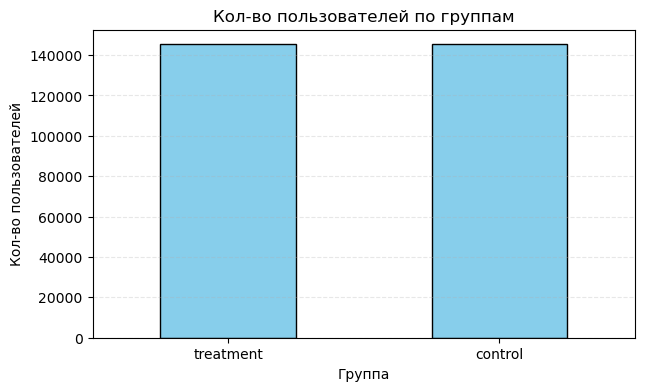

group
treatment    145311
control      145274
Name: count, dtype: int64

In [550]:
plt.figure(figsize=(7, 4))
df['group'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Группа")
plt.ylabel("Кол-во пользователей")
plt.title("Кол-во пользователей по группам")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle="--", alpha=0.3)
plt.show()

df['group'].value_counts()

Группа A и группа B распределены почти поровну

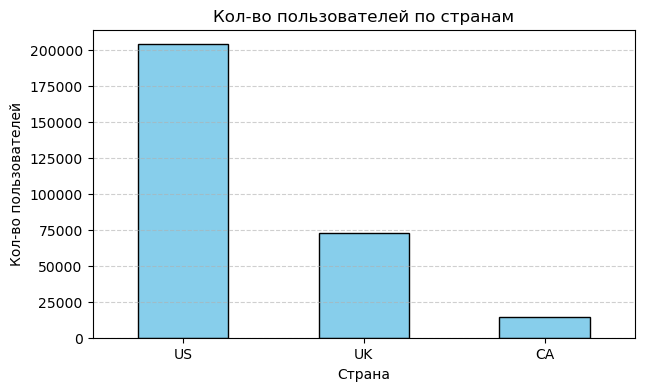

country
US    203620
UK     72466
CA     14499
Name: count, dtype: int64

In [599]:
plt.figure(figsize=(7, 4))
df['country'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Кол-во пользователей по странам")
plt.ylabel("Кол-во пользователей")
plt.xlabel("Страна")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

df['country'].value_counts()

Пользователей из US больше более чем в 2 раза, чем пользователей из UK и CA вместе взятых

### 3.2 Составлене гипотез  
• H₀: новая страница не увеличит конверсию  
• H₁: новая страница увеличит конверсию  
• Гипотеза, что эффект различается по странам

### 3.3 Проверка гипотез

In [376]:
convertion_rate = df.groupby('group')['converted'].agg(['mean', 'sum'])
convertion_rate.rename(columns={'mean': 'convertion', 'sum': 'count'})

,convertion,count
group,,
control,0.120386,17489
treatment,0.118807,17264


In [368]:
sample_1=df[df['group']=='control']['converted']
sample_2=df[df['group']=='treatment']['converted']

In [543]:
#Проверим гипотезы с помощью t-теста 

results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print(f"p_value: {results.pvalue:.4f}")
if results.pvalue < 0.05:
    print('Новая страница увеличилаа конверсию')
else:
    print('Новая страница НЕ увеличила конверсию')

p_value: 0.1897
Новая страница НЕ увеличила конверсию


In [545]:
#Проверим гипотезы с помощью z-теста 

convertion = [sample_1.sum(), sample_2.sum()]
total = [sample_1.count(), sample_2.count()]

z_stat, p_value = proportions_ztest(convertion, total, alternative='two-sided')

print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print('Новая страница увеличилаа конверсию')
else:
    print('Новая страница НЕ увеличила конверсию')

P-value: 0.1897
Новая страница НЕ увеличила конверсию


Оба теста показали, что новый дизайн страницы не увлечил конверсию. Но вдруг что-то изменилось в отдельных групах по странам?
Проведем z-тесты для каждой страны:
### 3.4 Анализ по сегментам (странам)

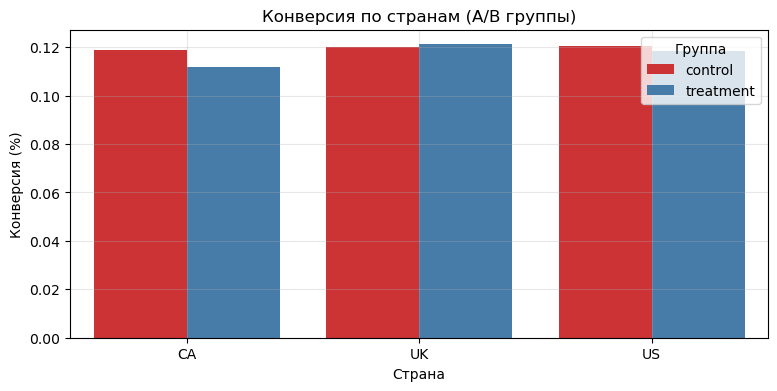

In [601]:
country_convertion.rename(columns={'mean': 'convertion', 'sum': 'count'})

plt.figure(figsize=(9, 4))
sns.barplot(data=country_convertion, x='country', y='mean', hue='group', palette='Set1')
plt.title('Конверсия по странам (A/B группы)')
plt.xlabel('Страна')
plt.ylabel('Конверсия (%)')
plt.legend(title='Группа')
plt.grid(alpha=0.3)
plt.show()

На первый взгляд, конверсия во всех группах одинаковая

In [610]:
#Разобъем данные на отдельные выборки:
sample_CA_1=df[(df['group']=='control')&(df['country']=='CA')]['converted']
sample_CA_2=df[(df['group']=='treatment')&(df['country']=='CA')]['converted']

sample_UK_1=df[(df['group']=='control')&(df['country']=='UK')]['converted']
sample_UK_2=df[(df['group']=='treatment')&(df['country']=='UK')]['converted']

sample_US_1=df[(df['group']=='control')&(df['country']=='US')]['converted']
sample_US_2=df[(df['group']=='treatment')&(df['country']=='US')]['converted']

In [396]:
#Проверка гипотезы для Канады
convertion_CA = [sample_CA_1.sum(), sample_CA_2.sum()]
total_CA = [sample_CA_1.count(), sample_CA_2.count()]

z_stat, p_value = proportions_ztest(convertion_CA, total_CA, alternative='two-sided')

print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print('Новая страница увеличилаа конверсию для Канады')
else:
    print('Новая страница НЕ увеличила конверсию для Канады')

P-value: 0.1947
Новая страница НЕ увеличила конверсию для Канады


In [612]:
#Проверка гипотезы для Великобритании
convertion_UK = [sample_UK_1.sum(), sample_UK_2.sum()]
total_UK = [sample_UK_1.count(), sample_UK_2.count()]

z_stat, p_value = proportions_ztest(convertion_UK, total_UK, alternative='two-sided')

print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print('Новая страница увеличилаа конверсию для Великобритании')
else:
    print('Новая страница НЕ увеличила конверсию для Великобритании')

P-value: 0.6349
Новая страница НЕ увеличила конверсию для Великобритании


In [614]:
#Проверка гипотезы для США
convertion_US = [sample_US_1.sum(), sample_US_2.sum()]
total_US = [sample_US_1.count(), sample_US_2.count()]

z_stat, p_value = proportions_ztest(convertion_US, total_US, alternative='two-sided')

print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print('Новая страница увеличилаа конверсию для США')
else:
    print('Новая страница НЕ увеличила конверсию для США')

P-value: 0.1321
Новая страница НЕ увеличила конверсию для США


## 4. Заключение

В проекте был проведён анализ результатов A/B-теста, целью которого было определить, повлиял ли реддизайн главной страницы на конверсию пользователей сайта.  
После загрузки и первичной проверки данных были выявлены ошибки в структуре выборки:некоторые пользователи могли видеть как старую, так и новую версию страницы. Это искажало распределение трафика и могло привести к ложным выводам. Для повышения корректности анализа были оставлены только уникальные пользователи.  

Далее данные были очищены и преобразованы:  
-унифицирован формат времени (timestamp)  
-проверена сбалансированность выборок между контрольной (control) и тестовой (treatment) группами  
-рассчитана конверсия по странам и по группам.  

Для проверки статистической значимости разницы в конверсии был проведён z-тест для пропорций, а также t-тест в качестве дополнительной проверки.
Оба теста показали p-value > 0.05, что не позволяет отвергнуть нулевую гипотезу. Это означает, что между контрольной и тестовой группами нет статистически значимых различий.
Дополнительный анализ по странам также не выявил сегментов, в которых новая версия страницы показала бы улучшение конверсии. Конверсия осталась на прежнем уровне во всех регионах.  

**Вывод:**  
Редизайн страницы не оказал влияния на поведение пользователей и не привёл к росту ключевой метрики — конверсии. Вероятнее всего, изменения в интерфейсе носили визуальный или несущественный характер, не затрагивающий этап принятия решения пользователем.